In [1]:
import pandas as pd
import datetime
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import plotly.graph_objects as go


In [2]:
#데이터 불러오기
df_buy_split = pd.read_csv('df_buy_split.csv') #구매내역 있는 고객의 CLICK STREAM 세션 분할 데이터
df_n_buy_split = pd.read_csv('df_n_buy_split.csv') #구매내역 없는 고객의 CLICK STREAM 세션 분할 데이터
click_stream = pd.read_csv('C:/Users/hm981/OneDrive/바탕 화면/AI부트캠프/project/teamproject2/data_refine/click_stream_final.csv')
transaction = pd.read_csv('C:/Users/hm981/OneDrive/바탕 화면/AI부트캠프/project/teamproject2/data_refine/transaction_final.csv')
product = pd.read_csv('C:/Users/hm981/OneDrive/바탕 화면/AI부트캠프/project/teamproject2/data_refine/product_final.csv')
customer_add_rfm = pd.read_csv('C:/Users/hm981/OneDrive/바탕 화면/AI부트캠프/project/teamproject2/customer_add_rfm.csv')

In [3]:
#고객 정보 병합
df_buy_split_cus = pd.merge(df_buy_split, customer_add_rfm, on ='customer_id', how = 'left')
df_buy_split_cus.rename(columns = {'RFM_Segment_y' : "RFM_Segment"}, inplace = True)
df_buy_split_cus.drop(columns = ['RFM_Segment_x'], inplace = True)

In [4]:
# 데이터프레임에서 'event_time' 열을 날짜 형식으로 변환
df_buy_split_cus['event_time'] = pd.to_datetime(df_buy_split_cus['event_time'])

# 시작 및 종료 날짜 설정
start_date = pd.to_datetime('2020-08-01')
end_date = pd.to_datetime('2022-07-31')

In [5]:
#데이터 타입 변경
df_session = df_buy_split_cus[['session_id', 'event_name', 'event_time', 'booking_id', 'gender', 'customer_id', 'first_join_date', 'age_now', 'home_location', 'RFM_Segment']]
df_session.loc[:,'event_name'] = df_session.loc[:,'event_name'].astype('category')
df_session.loc[:, 'gender'] = df_session.loc[:, 'gender'].astype('category')
df_session.loc[:, 'customer_id'] = df_session.loc[:, 'customer_id'].astype('int64')
df_session.loc[:, 'age_now'] = df_session.loc[:, 'age_now'].astype('int32')
df_session.loc[:, 'home_location'] = df_session.loc[:, 'home_location'].astype('category')

성별 데이터 분류

In [6]:
df_session_f = df_session[df_session.gender == 'F']
df_session_m = df_session[df_session.gender == 'M']

나이 데이터 분류

In [7]:
df_session_0_to_14 = df_session[df_session['age_now'] <= 14]
df_session_15_to_20 = df_session[(df_session['age_now'] <= 20) & ((df_session['age_now'] >= 15))]
df_session_21_to_25 = df_session[(df_session['age_now'] <= 25) & ((df_session['age_now'] >= 21))]
df_session_26_to_30 = df_session[(df_session['age_now'] <= 30) & ((df_session['age_now'] >= 26))]
df_session_31_to_35 = df_session[(df_session['age_now'] <= 35) & ((df_session['age_now'] >= 31))]
df_session_36_and_above = df_session[df_session['age_now'] >= 15]


## 성별 별 세션 분포

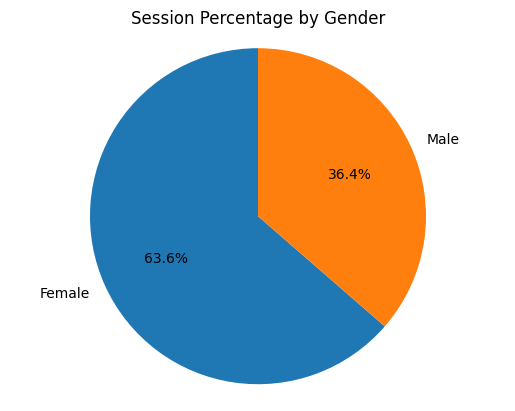

In [8]:

plt.pie([df_session_f.session_id.nunique(), df_session_m.session_id.nunique()], labels=['Female', 'Male'], autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # 차트를 원형으로 보이게 함
plt.title('Session Percentage by Gender')
plt.show()


## 나이 별 세션 분포

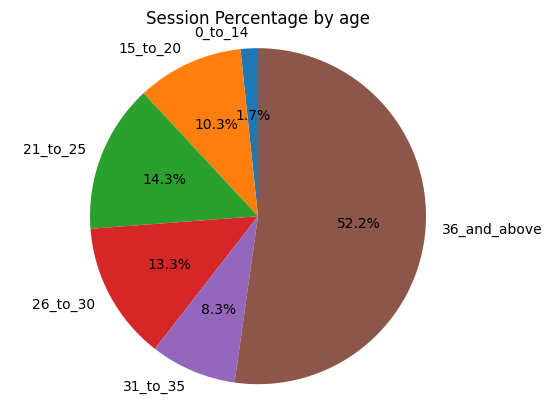

In [9]:
size = [df_session_0_to_14.session_id.nunique(), df_session_15_to_20.session_id.nunique(), df_session_21_to_25.session_id.nunique(), df_session_26_to_30.session_id.nunique(), df_session_31_to_35.session_id.nunique(), df_session_36_and_above.session_id.nunique()]
plt.pie(size, labels=['0_to_14', '15_to_20', '21_to_25', '26_to_30', '31_to_35', '36_and_above'], autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # 차트를 원형으로 보이게 함
plt.title('Session Percentage by age')
plt.show()


## 전체 기간 월별 전환률

In [10]:
monthly_data = df_session.groupby(pd.Grouper(key='event_time', freq='M'))

conversion_rate = pd.DataFrame(columns=['year/month', "conversion rate"])
m_l = []
c_r = []

# 그룹들 가져오기
groups = list(monthly_data.groups.keys())
# 마지막 그룹 제외한 나머지 그룹에 대해 루프 실행
for i in range(len(groups) - 1):
    month = groups[i]
    row = monthly_data.get_group(month)
    c_r.append(row.groupby('event_name').size()['BOOKING'] / row.session_id.nunique())
    m_l.append(month.strftime('%Y-%m'))

conversion_rate['year/month'] = m_l
conversion_rate['conversion rate'] = c_r


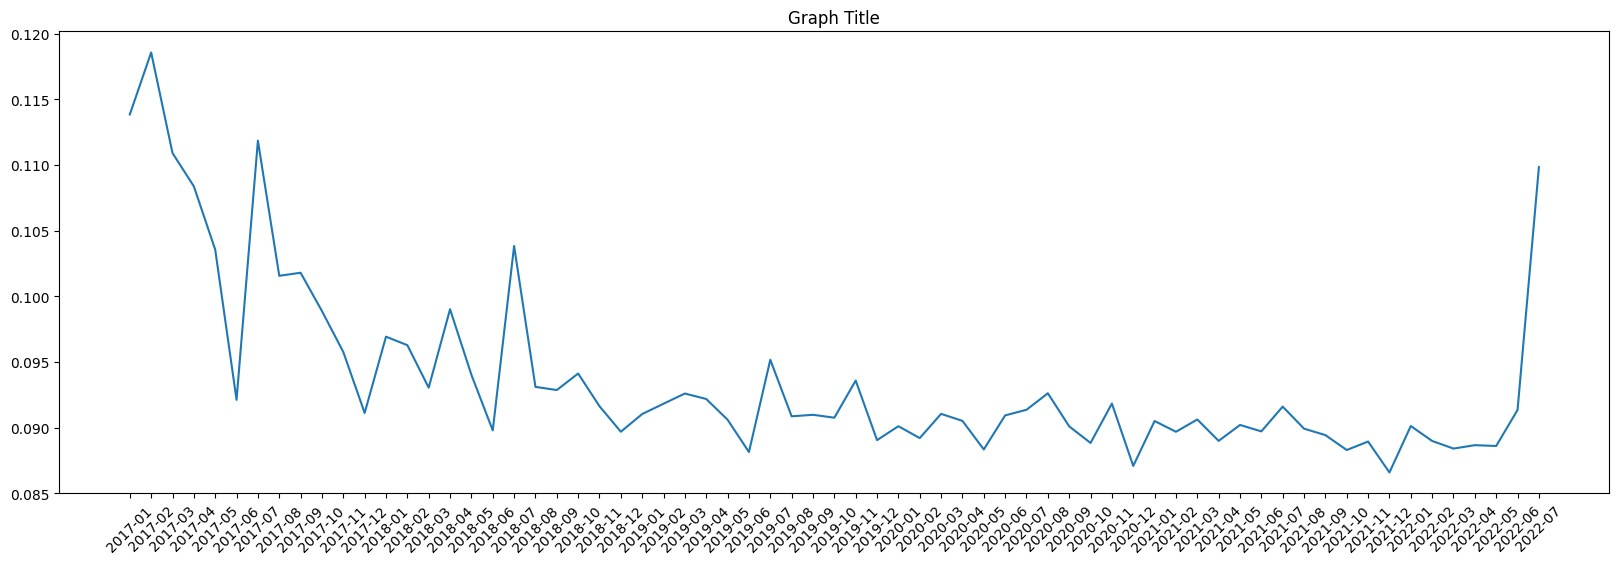

In [11]:

# x축과 y축 데이터
x = conversion_rate['year/month'][7:]
y = conversion_rate['conversion rate'][7:]

# 그래프 
plt.figure(figsize=(20, 6))
plt.plot(x, y)
plt.xticks(rotation= 45)

plt.title('Graph Title')
plt.show()


In [12]:
x_tick = ['2020/08', '2020/09', '2020/10', '2020/11', '2020/12',
'2021/01', '2021/02', '2021/03', '2021/04', '2021/05', '2021/06', '2021/07', '2021/08', '2021/09', '2021/10', '2021/11', '2021/12',
'2022/01', '2022/02', '2022/03', '2022/04', '2022/05', '2022/06', '2022/07']

In [13]:
def monthly_conversion(df):
    # 시작 날짜부터 종료 날짜까지의 범위에 해당하는 행 필터링
    fil_df = df[(pd.to_datetime(df['event_time'].date()) >= start_date) & (pd.to_datetime(df['event_time'].date()) <= end_date)]

    # 월별로 데이터 분할
    month_df = fil_df.groupby(pd.Grouper(key='event_time', freq='M'))

    con_df = pd.DataFrame(columns=['year/month', "conversion rate"])
    m_l = []
    c_r = []
    for month, row in month_df:
        c_r.append(row.groupby('event_name').size()['BOOKING']/row.session_id.nunique())
        m_l.append(month.strftime('%Y-%m'))
    con_df['year/month'] = m_l
    con_df['conversion rate'] = c_r
    
    plt.figure(figsize=(10, 6))
    plt.plot(con_df['conversion rate'])
    plt.xticks(range(0, 24), x_tick, rotation= 45)
    plt.show;

In [14]:
#구매내역 있는 데이터 없는 데이터 합친 전체 데이터 내보내기
df_session_b = df_buy_split_cus[['session_id', 'event_name', 'event_time', 'customer_id', 'booking_id']].copy()
df_session_n_b = df_n_buy_split[['session_id', 'event_name', 'event_time',]].copy()
df_session_n_b['customer_id'] = None
df_session_n_b['booking_id'] = None
df_session_con = pd.concat([df_session_b, df_session_n_b])
df_session_con.sort_values(['customer_id', 'session_id', 'event_time'], inplace = True)
df_session_con.reset_index(drop = True, inplace =True)
df_session_con.to_csv("df_session_con.csv", index = False)

In [15]:
df_session_con = pd.read_csv('C:/Users/hm981/OneDrive/바탕 화면/AI부트캠프/project/teamproject2/df_session_con.csv')

C:\Users\hm981\AppData\Local\Temp\ipykernel_27376\662664935.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_session_con = pd.read_csv('C:/Users/hm981/OneDrive/바탕 화면/AI부트캠프/project/teamproject2/df_session_con.csv')


# 세션 분석

세션 데이터 생성

In [16]:
df_session_con_group = df_session.groupby('session_id')
session_info = {}

#세션 아이디와 고객 아이디 매칭
for session, row in df_session_con_group:
    customer_id = row.iloc[0]['customer_id']
    session_info[session] = {'customer id': customer_id}

#세션 아이디별 이벤트 개수
for session, row in df_session_con_group:
    n_session = len(row)
    session_info[session].update({'number of events': n_session})
    
#세션 아이디별 이벤트 이름 리스트
for session, row in df_session_con_group:
    events = list(row['event_name'])
    session_info[session].update({'event list': events})
    
#세션 아이디별 이벤트간 시간차이
for session, row in df_session_con_group:
    first_event_time = row.loc[row.index[0], 'event_time']
    last_event_time = row.loc[row.index[-1], 'event_time']
    time_diff = (last_event_time - first_event_time).total_seconds()
    session_info[session].update({'session duration': time_diff})

In [17]:
#세션 데이터 데이터 프레임으로 변환
df_session_info = pd.DataFrame.from_dict(session_info, orient = 'index')

rfm = customer_add_rfm.copy()
rfm.drop(columns= ['RFM_Segment_x'], inplace= True)
rfm.rename(columns= {'RFM_Segment_y' : 'RFM_Segment'}, inplace= True)
rfm.gender = rfm.gender.astype('category')
rfm.age_segment = rfm.age_segment.astype('category')
rfm['RFM_Segment'] = rfm['RFM_Segment'].astype('category')

df_session_info.rename(columns = {"customer id" : 'customer_id'}, inplace = True)
df_session_info.reset_index(inplace = True)
df_session_info.rename(columns = {"index" : 'session_id'}, inplace = True)

df_session_info_rfm = pd.merge(df_session_info, rfm[['customer_id', 'RFM_Segment']], on = 'customer_id', how = 'left')

In [18]:
df_session_info_rfm.to_csv('df_session_info_rfm.csv', index = False)

세그먼트 데이터 분류

In [19]:
df_session_info_rfm['event list'] = df_session_info_rfm['event list'].apply(lambda x: x if isinstance(x, list) else [x])


In [20]:
df_session_info_rfm = pd.read_csv('df_session_info_rfm.csv')

In [21]:
df_session_info_rfm['time/event'] = df_session_info_rfm['session duration'] / df_session_info_rfm['number of events']

In [22]:
#각 세그먼트 별 전체 데이터
a_322 =  df_session_info_rfm[(df_session_info_rfm.RFM_Segment == 322)]
a_222 =  df_session_info_rfm[(df_session_info_rfm.RFM_Segment == 222)]
a_122 =  df_session_info_rfm[(df_session_info_rfm.RFM_Segment == 122)]

#각 세그먼트 별 세션 이벤트 수 1개 제외 데이터
n1_322 =  df_session_info_rfm[(df_session_info_rfm.RFM_Segment == 322)  & (df_session_info_rfm['number of events'] != 1)]
n1_222 =  df_session_info_rfm[(df_session_info_rfm.RFM_Segment == 222)  & (df_session_info_rfm['number of events'] != 1)]
n1_122 =  df_session_info_rfm[(df_session_info_rfm.RFM_Segment == 122)  & (df_session_info_rfm['number of events'] != 1)]

#각 세그먼트 별 세션 이벤트 수 1개 인 데이터
o1_322 =  df_session_info_rfm[(df_session_info_rfm.RFM_Segment == 322)  & (df_session_info_rfm['number of events'] == 1)]
o1_222 =  df_session_info_rfm[(df_session_info_rfm.RFM_Segment == 222)  & (df_session_info_rfm['number of events'] == 1)]
o1_122 =  df_session_info_rfm[(df_session_info_rfm.RFM_Segment == 122)  & (df_session_info_rfm['number of events'] == 1)]


In [23]:
def list_statistic(my_list):
    # NumPy를 사용하여 통계적 요약 정보 얻기
    list_mean = np.mean(my_list)
    list_std = np.std(my_list)
    list_min = np.min(my_list)
    list_max = np.max(my_list)
    list_median = np.median(my_list)
    list_quantiles = np.percentile(my_list, [25, 50, 75])

    # Pandas DataFrame으로 통계적 요약 정보 출력
    summary_df = pd.DataFrame({
        'mean': [list_mean],
        'std': [list_std],
        'min': [list_min],
        '25%': [list_quantiles[0]],
        '50%': [list_median],
        '75%': [list_quantiles[2]],
        'max': [list_max]
    })

    return summary_df


In [24]:
#322 그룹 세션 개수 통계
df_322_g = a_322.groupby('customer_id')
df_322_g_l = []
for g, row in df_322_g:
    df_322_g_l.append(row.session_id.nunique())
list_statistic(df_322_g_l)

#222 그룹 세션 개수 통계
df_222_g = a_222.groupby('customer_id')
df_222_g_l = []
for g, row in df_222_g:
    df_222_g_l.append(row.session_id.nunique())
list_statistic(df_222_g_l)

#122 그룹 세션 개수 통계
df_122_g = a_122.groupby('customer_id')
df_122_g_l = []
for g, row in df_122_g:
    df_122_g_l.append(row.session_id.nunique())
list_statistic(df_122_g_l)



,mean,std,min,25%,50%,75%,max
0,42.035577,30.923878,1,21.0,37.0,57.0,248


## 그룹별 평균 세션 수

### 전체 데이터

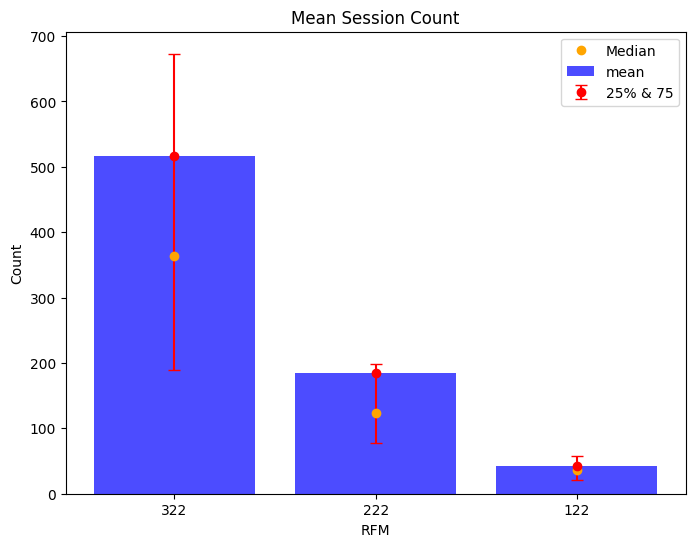

In [25]:

# x 축 값
segments = ['322', '222', '122']


# 세그먼트, 평균, 25%, 75% 값을 가진 리스트
means = np.array([list_statistic(df_322_g_l)['mean'][0], list_statistic(df_222_g_l)['mean'][0], list_statistic(df_122_g_l)['mean'][0]])
l_25 = np.array([list_statistic(df_322_g_l)['25%'][0], list_statistic(df_222_g_l)['25%'][0], list_statistic(df_122_g_l)['25%'][0]])
u_75 = np.array([(list_statistic(df_322_g_l)['75%'][0]), list_statistic(df_222_g_l)['75%'][0], list_statistic(df_122_g_l)['75%'][0]])
m_50 = np.array([(list_statistic(df_322_g_l)['50%'][0]), list_statistic(df_222_g_l)['50%'][0], list_statistic(df_122_g_l)['50%'][0]])


# 그래프 그리기
plt.figure(figsize=(8, 6))
plt.bar(segments, means, color = 'blue', alpha = 0.7, label = 'mean')
plt.errorbar(segments, means, yerr=[means - l_25, u_75 - means], fmt='o', capsize=4, label='25% & 75', color = 'red')
plt.plot(segments, m_50, 'o', label='Median', color = 'orange')
plt.xlabel('RFM')
plt.ylabel('Count')
plt.title('Mean Session Count')
plt.legend()

plt.show()


### 세션 길이 1인 데이터 제외

In [26]:
df_322_n1_g = n1_322.groupby('customer_id')
df_322_n1_g_l = []
for g, row in df_322_n1_g:
    df_322_n1_g_l.append(row.session_id.nunique())
list_statistic(df_322_n1_g_l)

,mean,std,min,25%,50%,75%,max
0,69.545613,66.868624,1,26.0,50.0,89.0,960


In [27]:
df_222_n1_g = n1_222.groupby('customer_id')
df_222_n1_g_l = []
for g, row in df_222_n1_g:
    df_222_n1_g_l.append(row.session_id.nunique())
list_statistic(df_222_n1_g_l)

,mean,std,min,25%,50%,75%,max
0,30.442633,45.18619,1,13.0,20.0,31.0,700


In [28]:
df_122_n1_g = n1_122.groupby('customer_id')
df_122_n1_g_l = []
for g, row in df_122_n1_g:
    df_122_n1_g_l.append(row.session_id.nunique())
list_statistic(df_122_n1_g_l)

,mean,std,min,25%,50%,75%,max
0,7.424038,4.542746,1,4.0,7.0,10.0,32


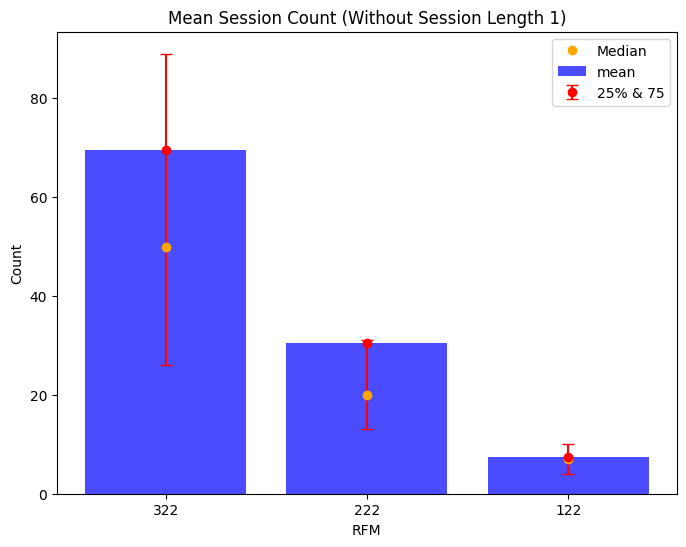

In [29]:

# 세그먼트, 평균, 25%, 75% 값을 가진 리스트
means = np.array([list_statistic(df_322_n1_g_l)['mean'][0], list_statistic(df_222_n1_g_l)['mean'][0], list_statistic(df_122_n1_g_l)['mean'][0]])
l_25 = np.array([list_statistic(df_322_n1_g_l)['25%'][0], list_statistic(df_222_n1_g_l)['25%'][0], list_statistic(df_122_n1_g_l)['25%'][0]])
u_75 = np.array([(list_statistic(df_322_n1_g_l)['75%'][0]), list_statistic(df_222_n1_g_l)['75%'][0], list_statistic(df_122_n1_g_l)['75%'][0]])
m_50 = np.array([(list_statistic(df_322_n1_g_l)['50%'][0]), list_statistic(df_222_n1_g_l)['50%'][0], list_statistic(df_122_n1_g_l)['50%'][0]])


# 그래프 그리기
plt.figure(figsize=(8, 6))
plt.bar(segments, means, color = 'blue', alpha = 0.7, label = 'mean')
plt.errorbar(segments, means, yerr=[means - l_25, u_75 - means], fmt='o', capsize=4, label='25% & 75', color = 'red')
plt.plot(segments, m_50, 'o', label='Median', color = 'orange')
plt.xlabel('RFM')
plt.ylabel('Count')
plt.title('Mean Session Count (Without Session Length 1)')
plt.legend()

plt.show()


### 세션 길이 1인 데이터

In [30]:
df_322_o1_g = o1_322.groupby('customer_id')
df_322_o1_g_l = []
for g, row in df_322_o1_g:
    df_322_o1_g_l.append(row.session_id.nunique())
list_statistic(df_322_o1_g_l)

,mean,std,min,25%,50%,75%,max
0,448.362089,438.444284,1,162.0,315.0,587.0,5537


In [31]:
df_222_o1_g = o1_222.groupby('customer_id')
df_222_o1_g_l = []
for g, row in df_222_o1_g:
    df_222_o1_g_l.append(row.session_id.nunique())
list_statistic(df_222_o1_g_l)

,mean,std,min,25%,50%,75%,max
0,154.752307,211.76242,1,63.0,103.0,167.0,2963


In [32]:
df_122_o1_g = o1_122.groupby('customer_id')
df_122_o1_g_l = []
for g, row in df_122_o1_g:
    df_122_o1_g_l.append(row.session_id.nunique())
list_statistic(df_122_o1_g_l)

,mean,std,min,25%,50%,75%,max
0,37.65272,27.688923,1,19.0,31.0,49.0,244


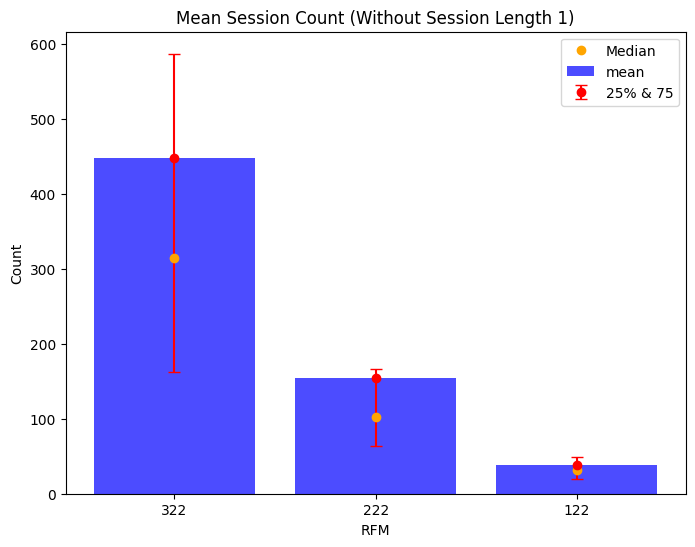

In [33]:

# 세그먼트, 평균, 25%, 75% 값을 가진 리스트
means = np.array([list_statistic(df_322_o1_g_l)['mean'][0], list_statistic(df_222_o1_g_l)['mean'][0], list_statistic(df_122_o1_g_l)['mean'][0]])
l_25 = np.array([list_statistic(df_322_o1_g_l)['25%'][0], list_statistic(df_222_o1_g_l)['25%'][0], list_statistic(df_122_o1_g_l)['25%'][0]])
u_75 = np.array([(list_statistic(df_322_o1_g_l)['75%'][0]), list_statistic(df_222_o1_g_l)['75%'][0], list_statistic(df_122_o1_g_l)['75%'][0]])
m_50 = np.array([(list_statistic(df_322_o1_g_l)['50%'][0]), list_statistic(df_222_o1_g_l)['50%'][0], list_statistic(df_122_o1_g_l)['50%'][0]])


# 그래프 그리기
plt.figure(figsize=(8, 6))
plt.bar(segments, means, color = 'blue', alpha = 0.7, label = 'mean')
plt.errorbar(segments, means, yerr=[means - l_25, u_75 - means], fmt='o', capsize=4, label='25% & 75', color = 'red')
plt.plot(segments, m_50, 'o', label='Median', color = 'orange')
plt.xlabel('RFM')
plt.ylabel('Count')
plt.title('Mean Session Count (Without Session Length 1)')
plt.legend()

plt.show()


## 마지막 이벤트 비율 분석

In [34]:

import ast

#각 세션의 마지막 이벤트 비율 추출 함수 정의
def last_event(df):
    event_counts = {}
    total_events = 0

    def get_last_event(row):
        nonlocal event_counts, total_events
        last_event = ast.literal_eval(row.iloc[-1]["event list"])[-1]
        event_counts[last_event] = event_counts.get(last_event, 0) + 1
        total_events += 1

    df.groupby('customer_id').apply(lambda x: x.groupby('session_id').apply(get_last_event))

    event_labels = list(event_counts.keys())
    event_ratios = [count / total_events for count in event_counts.values()]

    plt.pie(x=event_ratios, labels=event_labels)
    plt.show()

    return event_counts

### 전체데이터

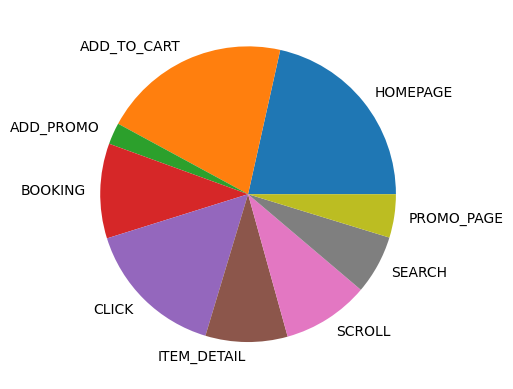

In [38]:
all_322_last = last_event(df_session_info_rfm[(df_session_info_rfm.RFM_Segment == 222)])

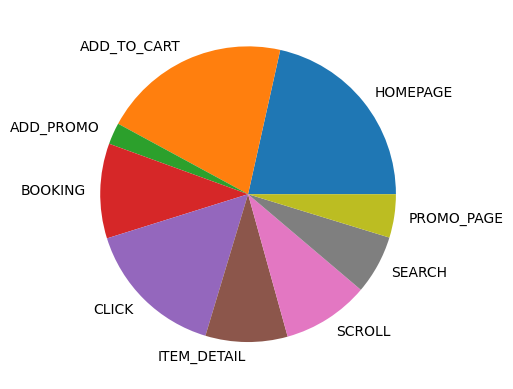

In [39]:
all_222_last = last_event(df_session_info_rfm[(df_session_info_rfm.RFM_Segment == 222)])

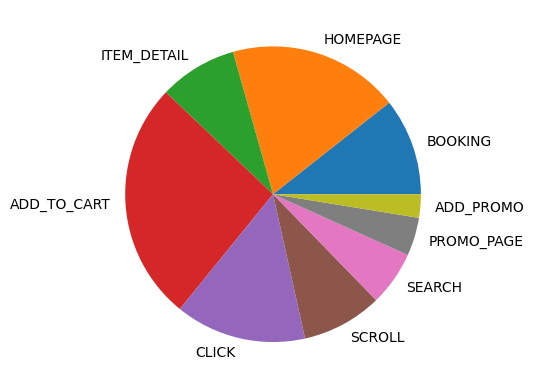

In [40]:
all_122_last = last_event(df_session_info_rfm[(df_session_info_rfm.RFM_Segment == 122)])

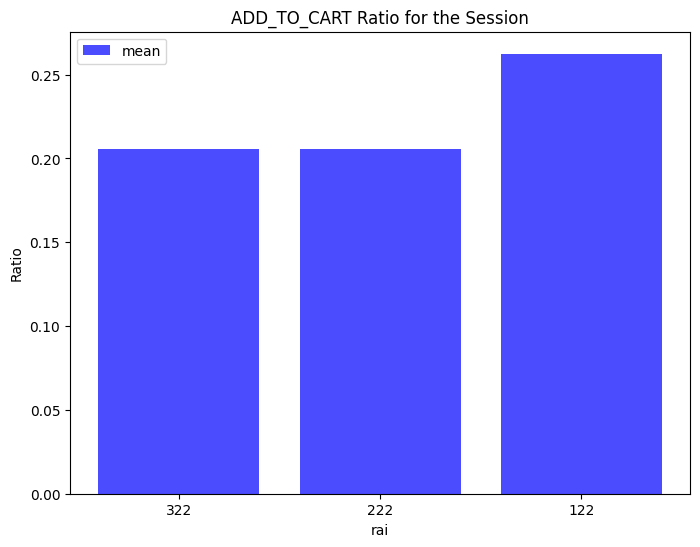

In [41]:
add_ses_all =[all_322_last['ADD_TO_CART'] / sum(all_322_last.values()), all_222_last['ADD_TO_CART'] / sum(all_222_last.values()), all_122_last['ADD_TO_CART'] / sum(all_122_last.values())]

# 그래프 그리기
plt.figure(figsize=(8, 6))
plt.bar(segments, add_ses_all, color = 'blue', alpha = 0.7, label = 'mean')
plt.xlabel('rai')
plt.ylabel('Ratio')
plt.title('ADD_TO_CART Ratio for the Session')
plt.legend()

plt.show()


### 세션 길이 1인 데이터 제외

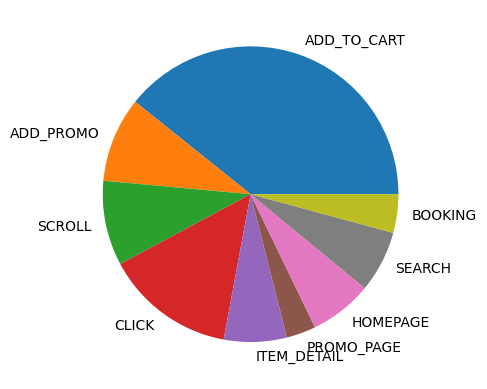

In [42]:
el1_322_last = last_event(df_session_info_rfm[(df_session_info_rfm.RFM_Segment == 322) & (df_session_info_rfm['number of events'] != 1)])

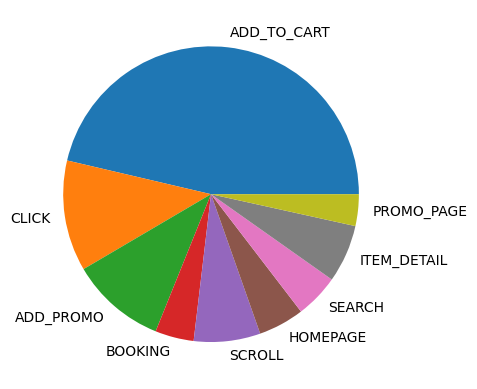

In [43]:
el1_222_last = last_event(df_session_info_rfm[(df_session_info_rfm.RFM_Segment == 222) & (df_session_info_rfm['number of events'] != 1)])

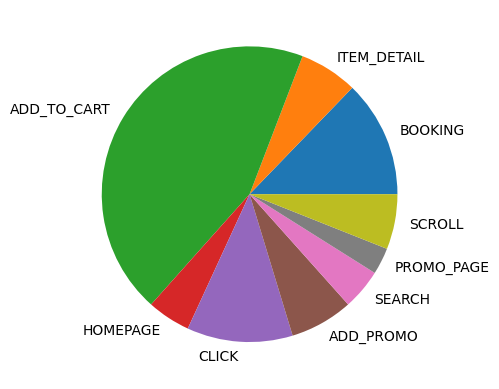

In [44]:
el1_122_last = last_event(df_session_info_rfm[(df_session_info_rfm.RFM_Segment == 122) & (df_session_info_rfm['number of events'] != 1)])

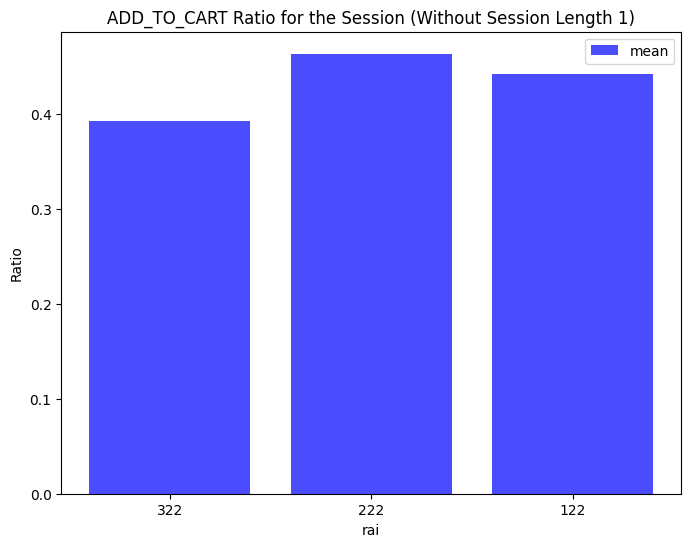

In [45]:
add_ses_el1 =[el1_322_last['ADD_TO_CART'] / sum(el1_322_last.values()), el1_222_last['ADD_TO_CART'] / sum(el1_222_last.values()), el1_122_last['ADD_TO_CART'] / sum(el1_122_last.values())]

# 그래프 그리기
plt.figure(figsize=(8, 6))
plt.bar(segments, add_ses_el1, color = 'blue', alpha = 0.7, label = 'mean')
plt.xlabel('rai')
plt.ylabel('Ratio')
plt.title('ADD_TO_CART Ratio for the Session (Without Session Length 1)')
plt.legend()

plt.show()


### 세션 길이 1인 데이터

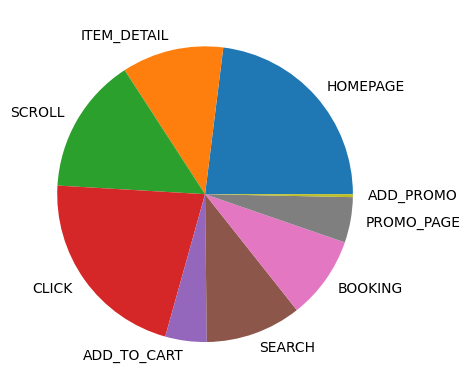

In [46]:
o1_322_last = last_event(df_session_info_rfm[(df_session_info_rfm.RFM_Segment == 322) & (df_session_info_rfm['number of events'] == 1)])

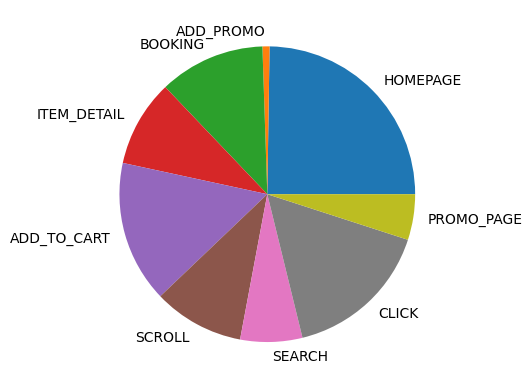

In [47]:
o1_222_last = last_event(df_session_info_rfm[(df_session_info_rfm.RFM_Segment == 222) & (df_session_info_rfm['number of events'] == 1)])

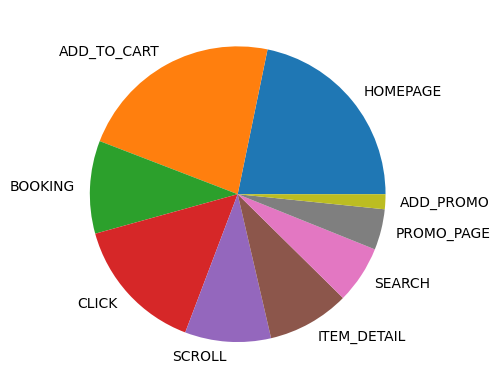

In [48]:
o1_122_last = last_event(df_session_info_rfm[(df_session_info_rfm.RFM_Segment == 122) & (df_session_info_rfm['number of events'] == 1)])

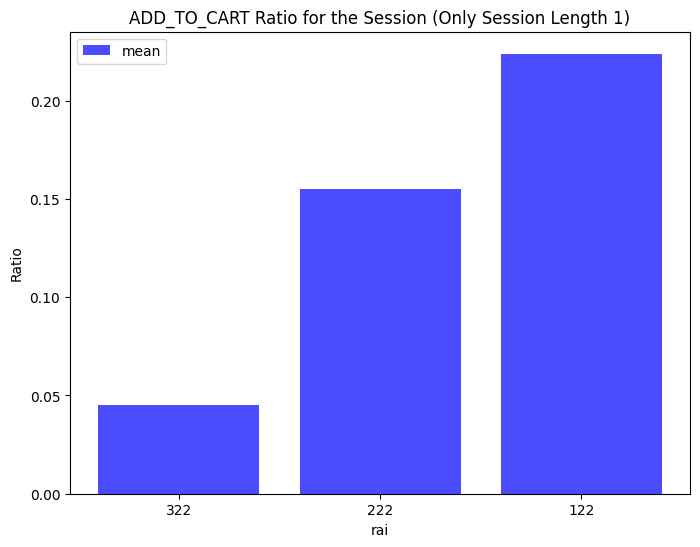

In [49]:
add_ses_o1 =[o1_322_last['ADD_TO_CART'] / sum(o1_322_last.values()), o1_222_last['ADD_TO_CART'] / sum(o1_222_last.values()), o1_122_last['ADD_TO_CART'] / sum(o1_122_last.values())]

# 그래프 그리기
plt.figure(figsize=(8, 6))
plt.bar(segments, add_ses_o1, color = 'blue', alpha = 0.7, label = 'mean')
plt.xlabel('rai')
plt.ylabel('Ratio')
plt.title('ADD_TO_CART Ratio for the Session (Only Session Length 1)')
plt.legend()

plt.show()


In [50]:
raw_322 = df_session[df_session['RFM_Segment'] == 322]
raw_222 = df_session[df_session['RFM_Segment'] == 222]
raw_122 = df_session[df_session['RFM_Segment'] == 122]

## 월별 평균 세션 수 추이

In [51]:
raw_322_m = raw_322.groupby(pd.Grouper(key='event_time', freq='M'))
raw_222_m = raw_222.groupby(pd.Grouper(key='event_time', freq='M'))
raw_122_m = raw_122.groupby(pd.Grouper(key='event_time', freq='M'))

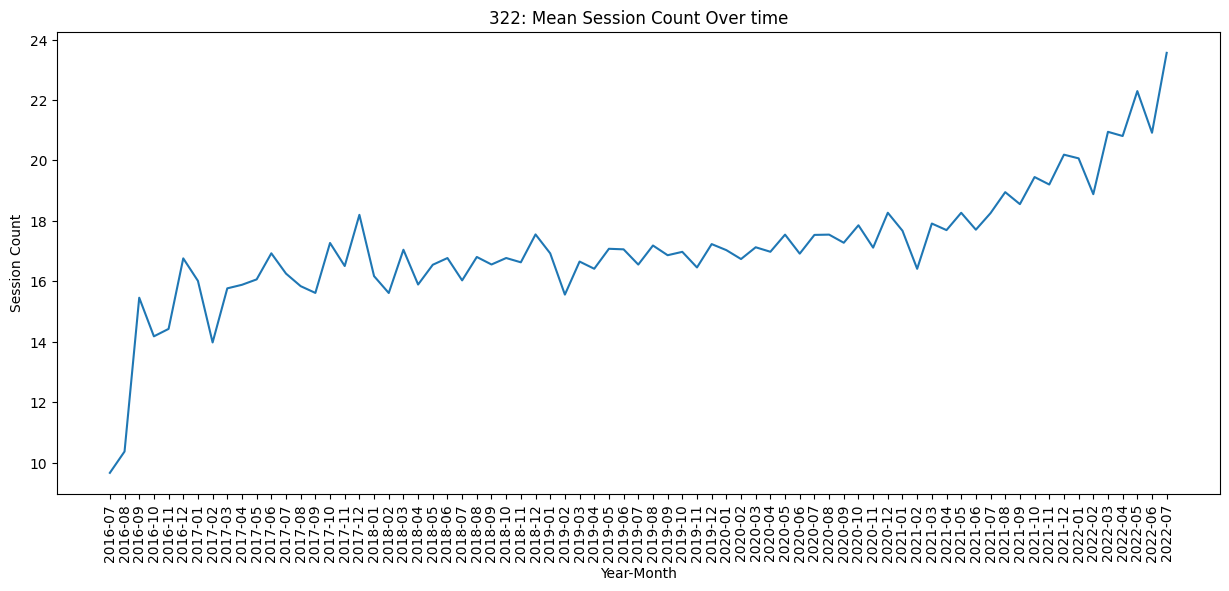

In [52]:
msc_322 = {}
for m, row in raw_322_m:
    cus_gr = row.groupby('customer_id')
    lis = []
    for cus, row_2 in cus_gr:
        lis.append(row_2.session_id.nunique())
    msc_322[m.strftime("%Y-%m")] = lis
        
df_msc_322 = pd.DataFrame()
for key in msc_322:
    df_msc_322[key] = list_statistic(msc_322[key]).iloc[0]

plt.figure(figsize=(15, 6))
plt.plot(df_msc_322.loc['mean'][:-1])
plt.xlabel('Year-Month')
plt.ylabel('Session Count')
plt.title('322: Mean Session Count Over time')
plt.xticks( rotation= 90)
plt.show()

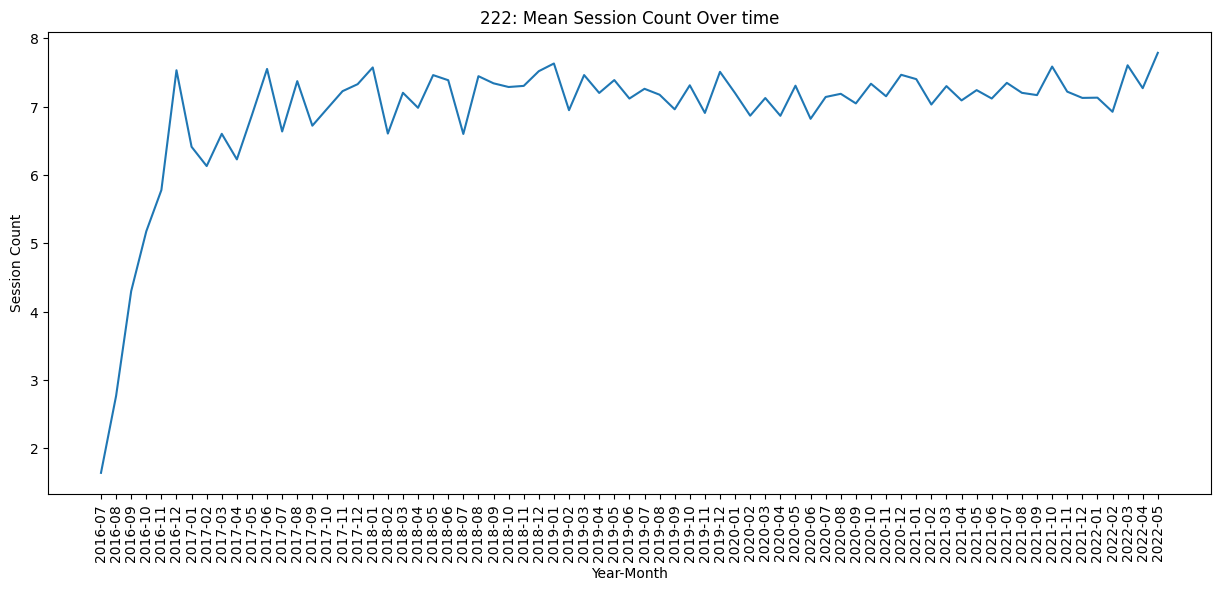

In [53]:
msc_222 = {}
for m, row in raw_222_m:
    cus_gr = row.groupby('customer_id')
    lis = []
    for cus, row_2 in cus_gr:
        lis.append(row_2.session_id.nunique())
    msc_222[m.strftime("%Y-%m")] = lis
        
df_msc_222 = pd.DataFrame()
for key in msc_222:
    df_msc_222[key] = list_statistic(msc_222[key]).iloc[0]

plt.figure(figsize=(15, 6))
plt.plot(df_msc_222.loc['mean'][:-1])
plt.xlabel('Year-Month')
plt.ylabel('Session Count')
plt.title('222: Mean Session Count Over time')
plt.xticks( rotation= 90)
plt.show()

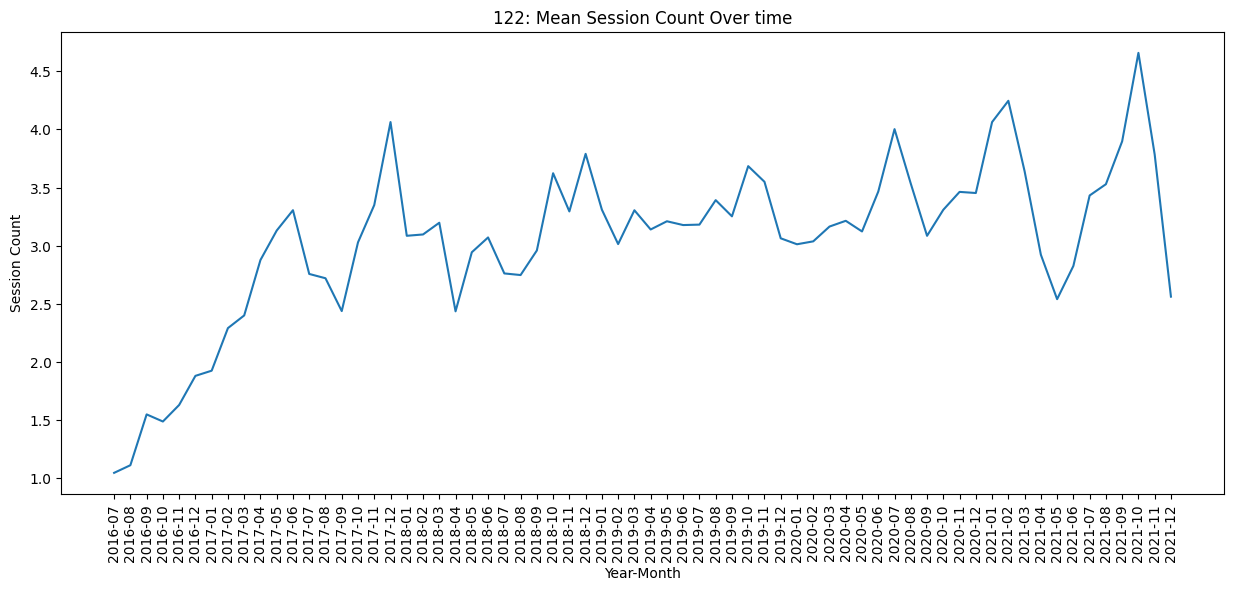

In [54]:
msc_122 = {}
for m, row in raw_122_m:
    cus_gr = row.groupby('customer_id')
    lis = []
    for cus, row_2 in cus_gr:
        lis.append(row_2.session_id.nunique())
    msc_122[m.strftime("%Y-%m")] = lis
        
df_msc_122 = pd.DataFrame()
for key in msc_122:
    df_msc_122[key] = list_statistic(msc_122[key]).iloc[0]

plt.figure(figsize=(15, 6))
plt.plot(df_msc_122.loc['mean'][:-1])
plt.xlabel('Year-Month')
plt.ylabel('Session Count')
plt.title('122: Mean Session Count Over time')
plt.xticks( rotation= 90)
plt.show()

## 월별 마지막 이벤트가 booking 인 비율 추이

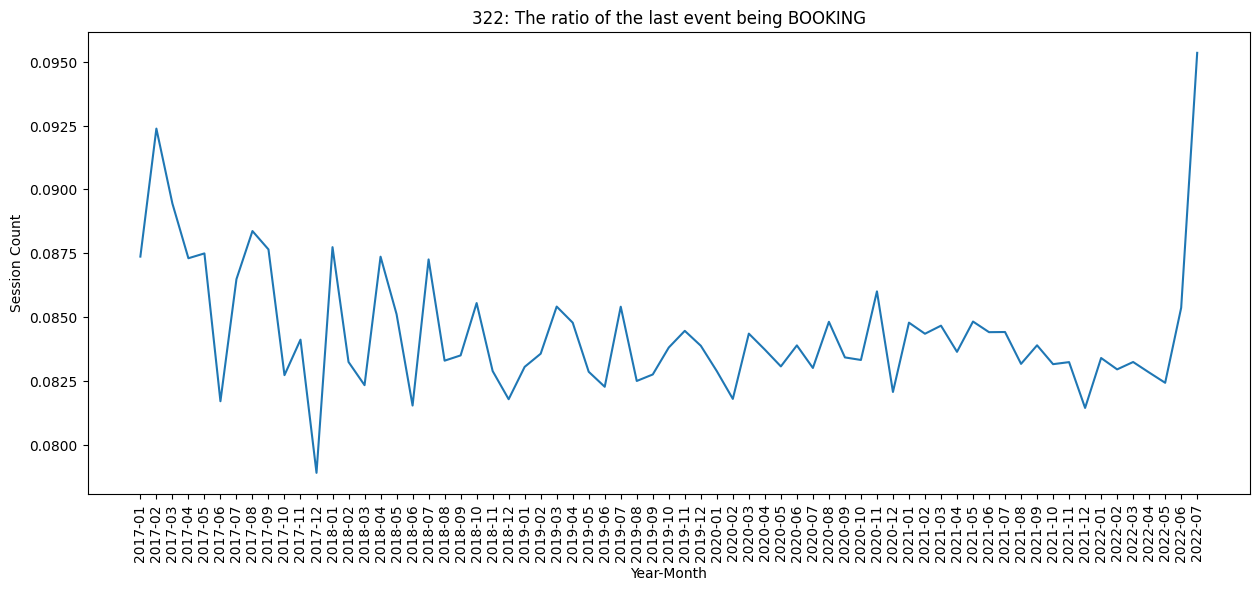

In [55]:
le_322 = {}

for m, row in raw_322_m:
    se_gr = row.groupby('session_id')['event_name'].last()
    event_counts = se_gr.value_counts()
    total_events = event_counts.sum()
    event_ratios = event_counts / total_events
    le_322[m] = dict(zip(event_counts.index, event_ratios))


le_book_322 = []
x_tick = []
for key in le_322:
    le_book_322.append(le_322[key].get('BOOKING'))
    x_tick.append(key.strftime("%Y-%m"))

plt.figure(figsize=(15, 6))
plt.plot(le_book_322[6:-1])
plt.xlabel('Year-Month')
plt.ylabel('Session Count')
plt.title('322: The ratio of the last event being BOOKING')
plt.xticks(range(len(x_tick[6:-1])), x_tick[6:-1], rotation= 90)
plt.show()


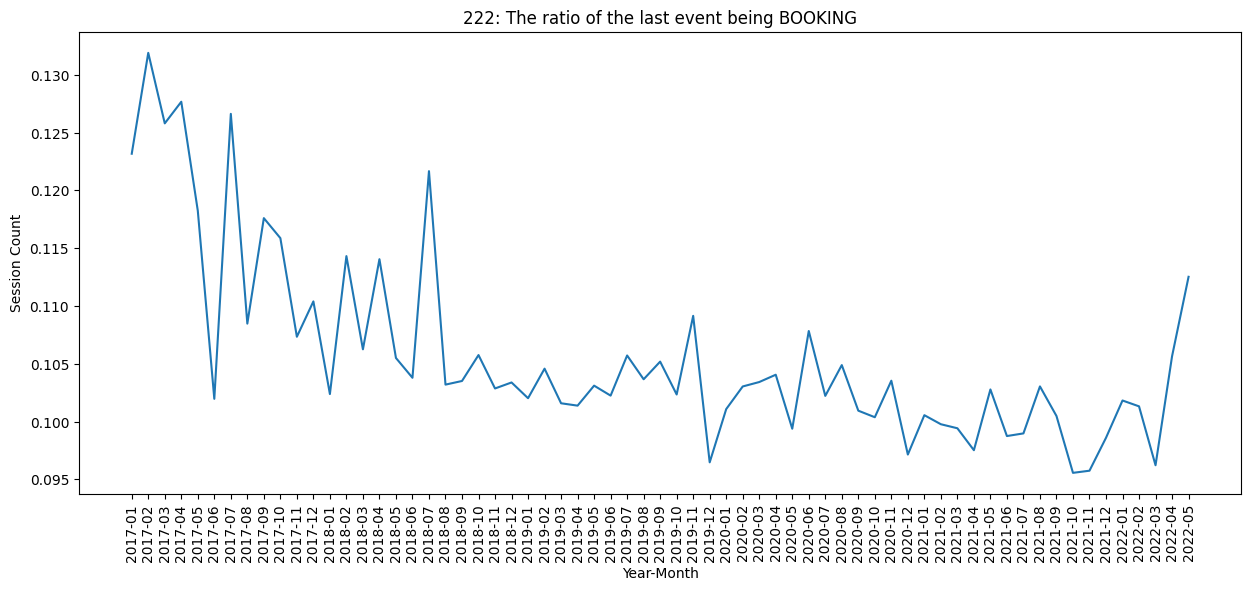

In [56]:
le_222 = {}

for m, row in raw_222_m:
    se_gr = row.groupby('session_id')['event_name'].last()
    event_counts = se_gr.value_counts()
    total_events = event_counts.sum()
    event_ratios = event_counts / total_events
    le_222[m] = dict(zip(event_counts.index, event_ratios))


le_book_222 = []
x_tick = []
for key in le_222:
    le_book_222.append(le_222[key].get('BOOKING'))
    x_tick.append(key.strftime("%Y-%m"))

plt.figure(figsize=(15, 6))
plt.plot(le_book_222[6:-1])
plt.xlabel('Year-Month')
plt.ylabel('Session Count')
plt.title('222: The ratio of the last event being BOOKING')
plt.xticks(range(len(x_tick[6:-1])), x_tick[6:-1], rotation= 90)
plt.show()


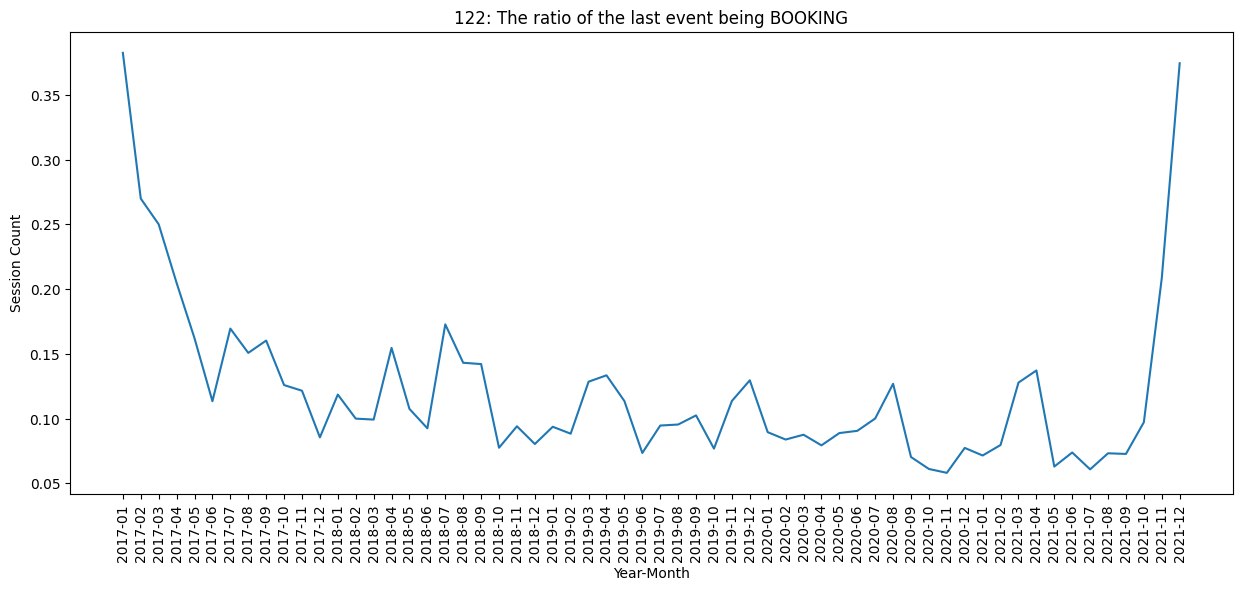

In [57]:
le_122 = {}

for m, row in raw_122_m:
    se_gr = row.groupby('session_id')['event_name'].last()
    event_counts = se_gr.value_counts()
    total_events = event_counts.sum()
    event_ratios = event_counts / total_events
    le_122[m] = dict(zip(event_counts.index, event_ratios))


le_book_122 = []
x_tick = []
for key in le_122:
    le_book_122.append(le_122[key].get('BOOKING'))
    x_tick.append(key.strftime("%Y-%m"))

plt.figure(figsize=(15, 6))
plt.plot(le_book_122[6:-1])
plt.xlabel('Year-Month')
plt.ylabel('Session Count')
plt.title('122: The ratio of the last event being BOOKING')
plt.xticks(range(len(x_tick[6:-1])), x_tick[6:-1], rotation= 90)
plt.show()


## 월별 마지막 이벤트가 add_to_cart 인 비율 추이

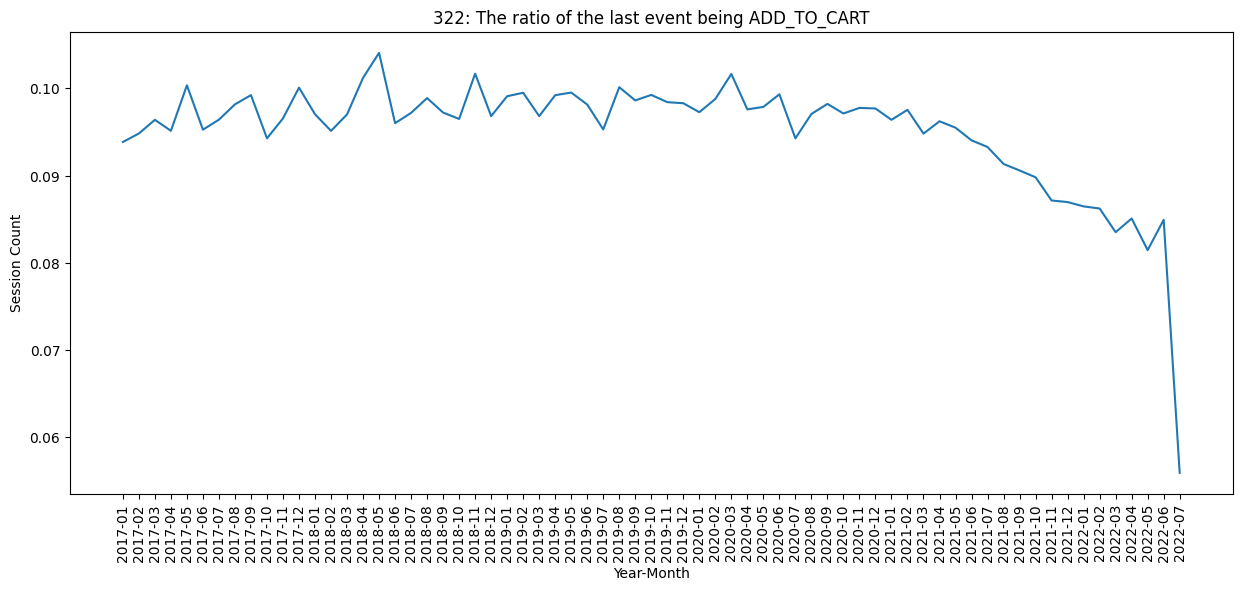

In [58]:
le_add_322 = []
x_tick = []
for key in le_322:
    le_add_322.append(le_322[key].get('ADD_TO_CART'))
    x_tick.append(key.strftime("%Y-%m"))

plt.figure(figsize=(15, 6))
plt.plot(le_add_322[6:-1])
plt.xlabel('Year-Month')
plt.ylabel('Session Count')
plt.title('322: The ratio of the last event being ADD_TO_CART')
plt.xticks(range(len(x_tick[6:-1])), x_tick[6:-1], rotation= 90)
plt.show()

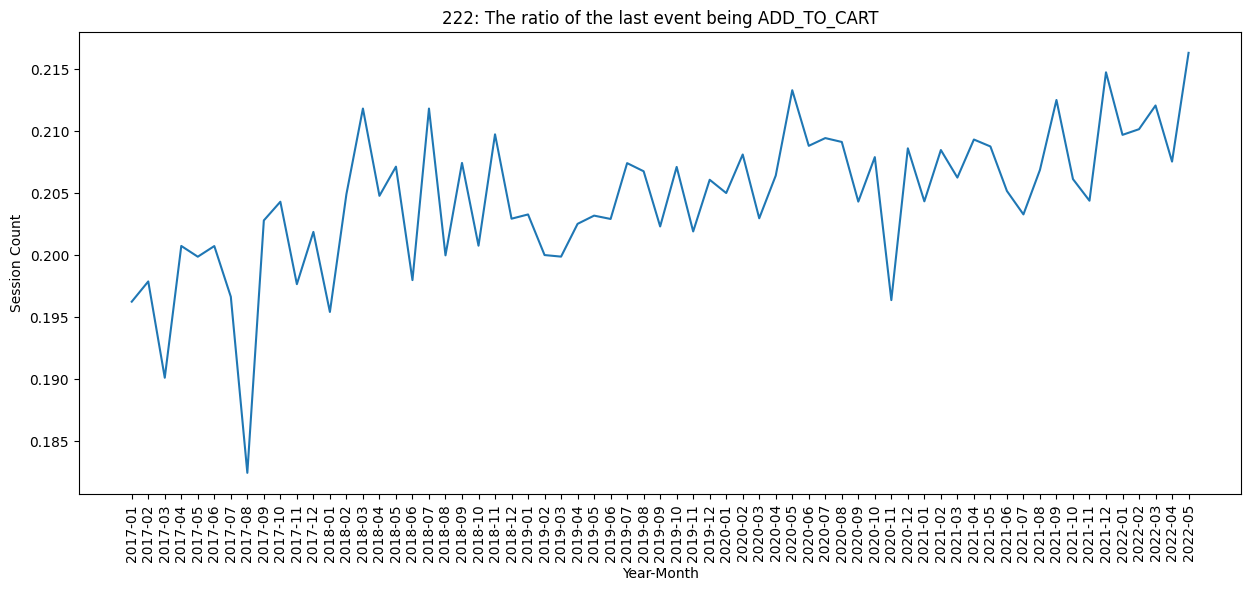

In [59]:
le_add_222 = []
x_tick = []
for key in le_222:
    le_add_222.append(le_222[key].get('ADD_TO_CART'))
    x_tick.append(key.strftime("%Y-%m"))

plt.figure(figsize=(15, 6))
plt.plot(le_add_222[6:-1])
plt.xlabel('Year-Month')
plt.ylabel('Session Count')
plt.title('222: The ratio of the last event being ADD_TO_CART')
plt.xticks(range(len(x_tick[6:-1])), x_tick[6:-1], rotation= 90)
plt.show()

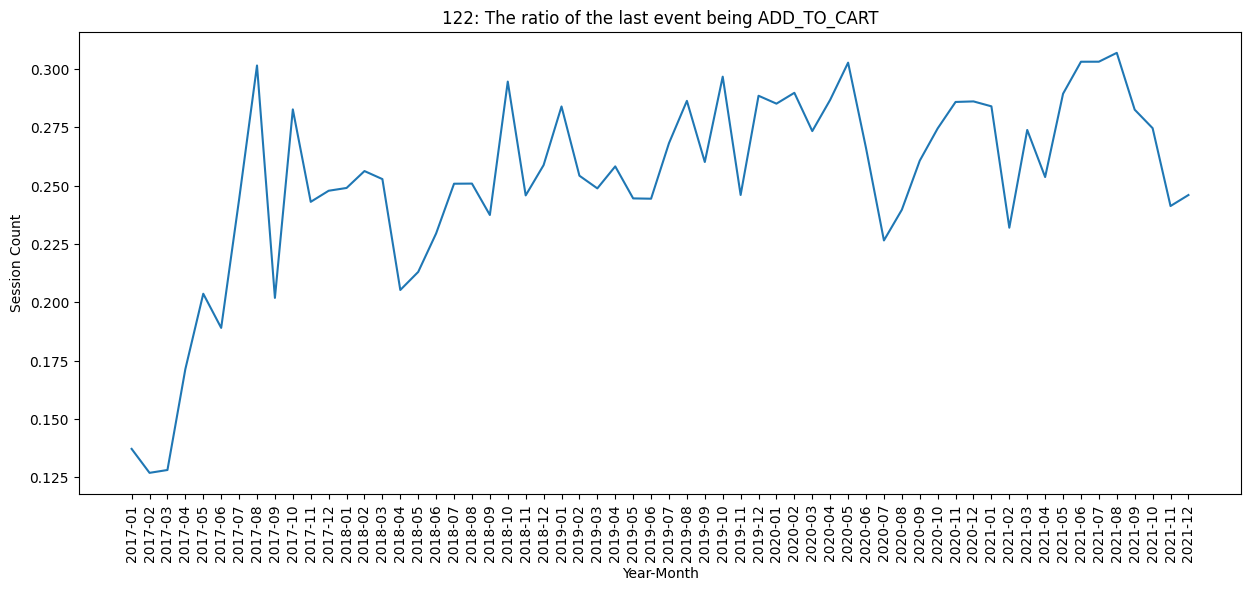

In [60]:
le_add_122 = []
x_tick = []
for key in le_122:
    le_add_122.append(le_122[key].get('ADD_TO_CART'))
    x_tick.append(key.strftime("%Y-%m"))

plt.figure(figsize=(15, 6))
plt.plot(le_add_122[6:-1])
plt.xlabel('Year-Month')
plt.ylabel('Session Count')
plt.title('122: The ratio of the last event being ADD_TO_CART')
plt.xticks(range(len(x_tick[6:-1])), x_tick[6:-1], rotation= 90)
plt.show()

## 월별 add_to_cart 에서 booking으로의 전환률 차이

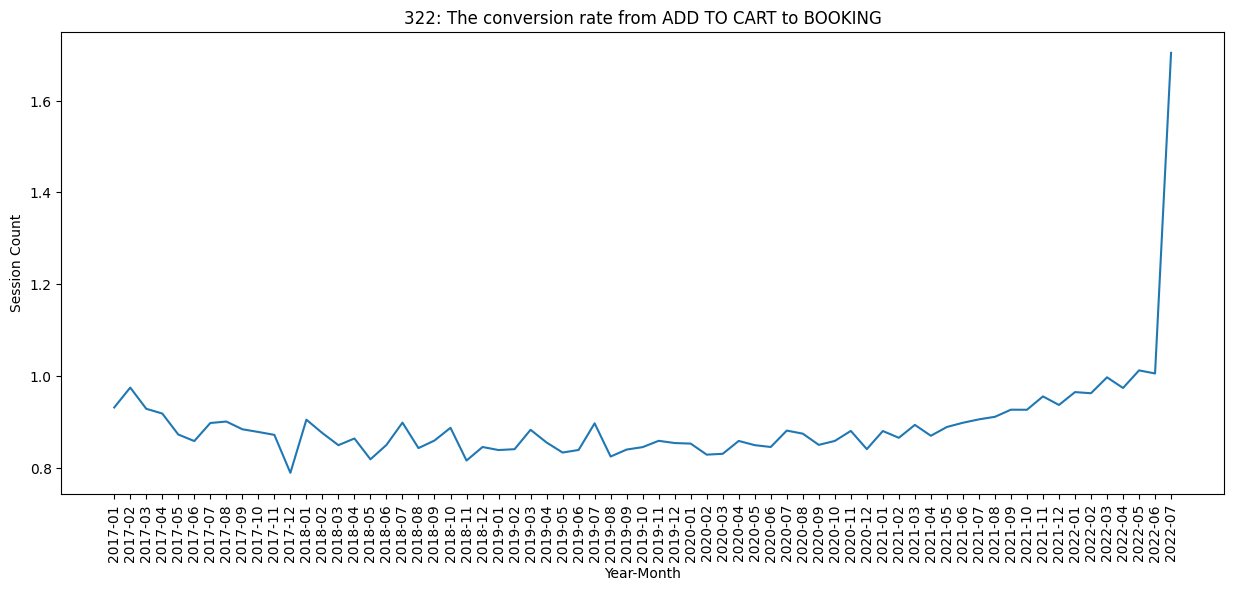

In [61]:
le_book_per_add_322 = []
x_tick = []
keys = list(le_322.keys())  # keys를 리스트로 변환하여 인덱스 접근이 가능하도록 함
last_key = keys[-1]  # 마지막 key 저장

for key in keys:
    if key == last_key:  # 마지막 key일 경우 반복문 실행 건너뛰기
        continue

    le_book_per_add_322.append(le_322[key].get('BOOKING') / le_322[key].get('ADD_TO_CART'))
    x_tick.append(key.strftime("%Y-%m"))

plt.figure(figsize=(15, 6))
plt.plot(le_book_per_add_322[6:])
plt.xlabel('Year-Month')
plt.ylabel('Session Count')
plt.title('322: The conversion rate from ADD TO CART to BOOKING')
plt.xticks(range(len(x_tick[6:])), x_tick[6:], rotation=90)
plt.show()


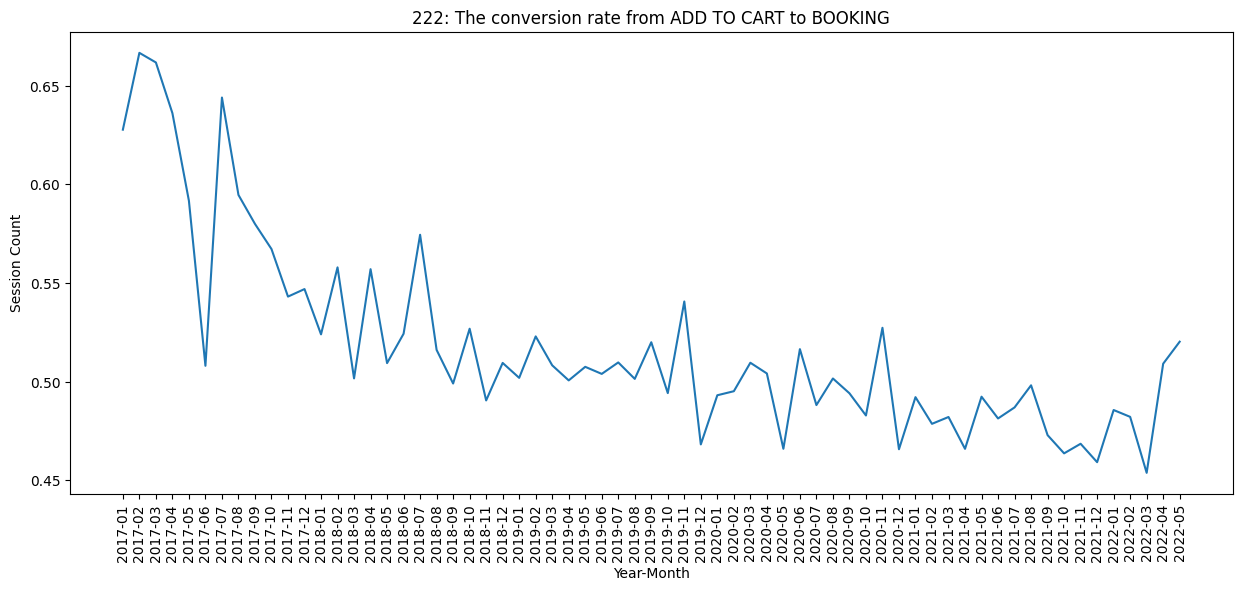

In [62]:
le_book_per_add_222 = []
x_tick = []
keys = list(le_222.keys())  # keys를 리스트로 변환하여 인덱스 접근이 가능하도록 함
last_key = keys[-1]  # 마지막 key 저장

for key in keys:
    if key == last_key:  # 마지막 key일 경우 반복문 실행 건너뛰기
        continue

    le_book_per_add_222.append(le_222[key].get('BOOKING') / le_222[key].get('ADD_TO_CART'))
    x_tick.append(key.strftime("%Y-%m"))

plt.figure(figsize=(15, 6))
plt.plot(le_book_per_add_222[6:])
plt.xlabel('Year-Month')
plt.ylabel('Session Count')
plt.title('222: The conversion rate from ADD TO CART to BOOKING')
plt.xticks(range(len(x_tick[6:])), x_tick[6:], rotation=90)
plt.show()


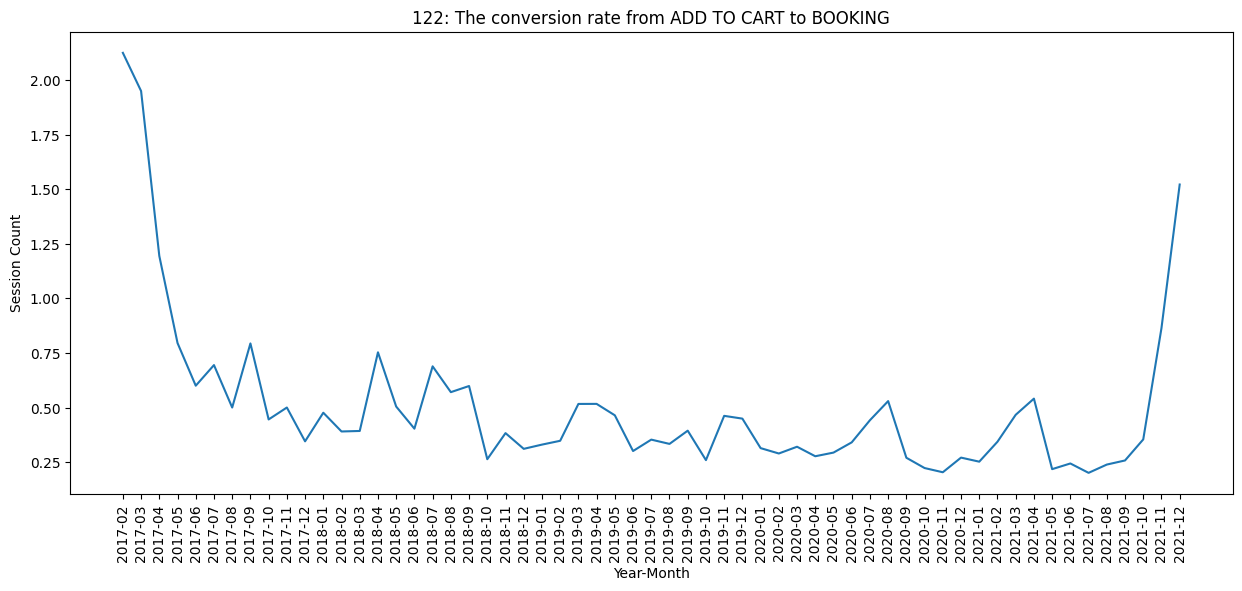

In [63]:
le_book_per_add_122 = []
x_tick = []
keys = list(le_122.keys())  # keys를 리스트로 변환하여 인덱스 접근이 가능하도록 함
last_key = keys[-1]  # 마지막 key 저장

for key in keys:
    if key == last_key:  # 마지막 key일 경우 반복문 실행 건너뛰기
        continue

    booking_count = le_122[key].get('BOOKING')
    add_to_cart_count = le_122[key].get('ADD_TO_CART')

    # NoneType 예외 처리
    if booking_count is None or add_to_cart_count is None:
        continue

    le_book_per_add_122.append(booking_count / add_to_cart_count)
    x_tick.append(key.strftime("%Y-%m"))

plt.figure(figsize=(15, 6))
plt.plot(le_book_per_add_122[6:])
plt.xlabel('Year-Month')
plt.ylabel('Session Count')
plt.title('122: The conversion rate from ADD TO CART to BOOKING')
plt.xticks(range(len(x_tick[6:])), x_tick[6:], rotation=90)
plt.show()


## 그룹별 pro 이용 비율

### 전체 데이터

In [64]:
pro_322 = df_buy_split_cus[['booking_id', 'event_time', 'promo_code', 'customer_id', 'promo_amount', 'RFM_Segment']][(df_buy_split_cus['RFM_Segment'] == 322)]
pro_222 = df_buy_split_cus[['booking_id', 'event_time', 'promo_code', 'customer_id', 'promo_amount', 'RFM_Segment']][(df_buy_split_cus['RFM_Segment'] == 222)]
pro_122 = df_buy_split_cus[['booking_id', 'event_time', 'promo_code', 'customer_id', 'promo_amount', 'RFM_Segment']][(df_buy_split_cus['RFM_Segment'] == 122)]

In [65]:
#
pro_322_g = pro_322.groupby('booking_id')
pro_ls = []
promo_code_count = 0

for b_i, row in pro_322_g:
    if row['promo_code'].any() != 0:
        promo_code_count += 1
pro_ls.append(promo_code_count / pro_322.booking_id.nunique())

#
pro_222_g = pro_222.groupby('booking_id')
promo_code_count = 0

for b_i, row in pro_222_g:
    if row['promo_code'].any() != 0:
        promo_code_count += 1
pro_ls.append(promo_code_count / pro_222.booking_id.nunique())

#
pro_122_g = pro_122.groupby('booking_id')
promo_code_count = 0

for b_i, row in pro_122_g:
    if row['promo_code'].any() != 0:
        promo_code_count += 1
pro_ls.append(promo_code_count / pro_122.booking_id.nunique())


In [66]:
pro_ls

[0.3740117210796187, 0.4299790047515562, 0.4493279283123533]

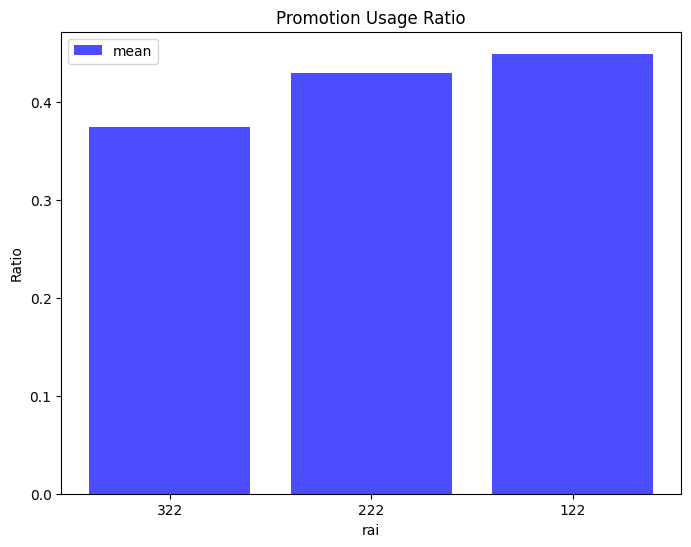

In [67]:


# 그래프 그리기
plt.figure(figsize=(8, 6))
plt.bar(segments, pro_ls, color = 'blue', alpha = 0.7, label = 'mean')
plt.xlabel('rai')
plt.ylabel('Ratio')
plt.title('Promotion Usage Ratio')
plt.legend()

plt.show()



### payment success 데이터

In [68]:
sus_book_322 = df_buy_split_cus[(df_buy_split_cus['RFM_Segment'] == 322) & (df_buy_split_cus['payment_status'] == 1)]['booking_id']
sus_book_222 = df_buy_split_cus[(df_buy_split_cus['RFM_Segment'] == 222) & (df_buy_split_cus['payment_status'] == 1)]['booking_id']
sus_book_122 = df_buy_split_cus[(df_buy_split_cus['RFM_Segment'] == 122) & (df_buy_split_cus['payment_status'] == 1)]['booking_id']


In [69]:
pro_322_s = df_buy_split_cus[['booking_id', 'event_time', 'promo_code', 'customer_id', 'promo_amount', 'RFM_Segment', 'payment_status']][df_buy_split_cus['booking_id'].isin(sus_book_322)]
pro_222_s = df_buy_split_cus[['booking_id', 'event_time', 'promo_code', 'customer_id', 'promo_amount', 'RFM_Segment', 'payment_status']][df_buy_split_cus['booking_id'].isin(sus_book_222)]
pro_122_s = df_buy_split_cus[['booking_id', 'event_time', 'promo_code', 'customer_id', 'promo_amount', 'RFM_Segment', 'payment_status']][df_buy_split_cus['booking_id'].isin(sus_book_122)]


In [70]:
#
pro_322_g_s = pro_322_s.groupby('booking_id')
pro_ls_s = []
promo_code_count = 0

for b_i, row in pro_322_g_s:
    if row['promo_code'].any() != 0:
        promo_code_count += 1
pro_ls_s.append(promo_code_count / pro_322_s.booking_id.nunique())

#
pro_222_g_s = pro_222_s.groupby('booking_id')
promo_code_count = 0

for b_i, row in pro_222_g_s:
    if row['promo_code'].any() != 0:
        promo_code_count += 1
pro_ls_s.append(promo_code_count / pro_222_s.booking_id.nunique())

#
pro_122_g_s = pro_122_s.groupby('booking_id')
promo_code_count = 0

for b_i, row in pro_122_g_s:
    if row['promo_code'].any() != 0:
        promo_code_count += 1
pro_ls_s.append(promo_code_count / pro_122_s.booking_id.nunique())


In [71]:
pro_ls_s

[0.3741906850459482, 0.4300966264163533, 0.44760845383759734]

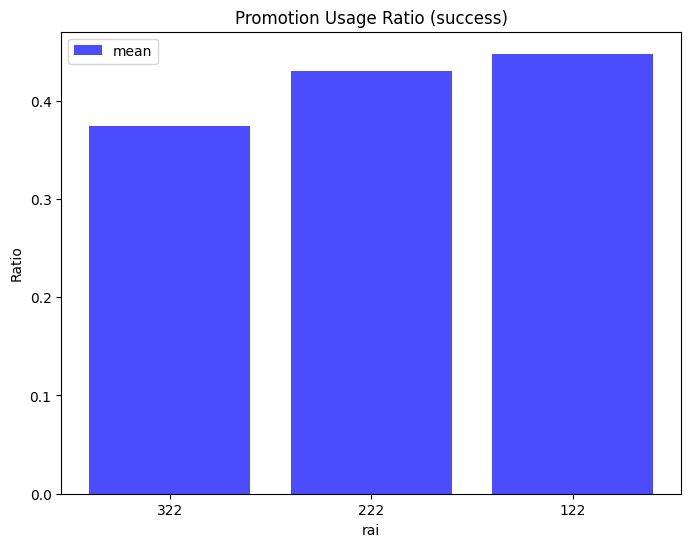

In [72]:


# 그래프 그리기
plt.figure(figsize=(8, 6))
plt.bar(segments, pro_ls_s, color = 'blue', alpha = 0.7, label = 'mean')
plt.xlabel('rai')
plt.ylabel('Ratio')
plt.title('Promotion Usage Ratio (success)')
plt.legend()

plt.show()





### 세션 지속 시간

In [73]:
a_322.groupby('customer_id')['session duration'].mean().describe()

count    13746.000000
mean       166.332667
std        249.165677
min          4.656695
25%         66.787655
50%        106.828809
75%        183.862655
max      11504.791019
Name: session duration, dtype: float64

In [74]:
a_222.groupby('customer_id')['session duration'].mean().describe()

count    8463.000000
mean      125.419883
std       130.088213
min         3.932562
25%        73.245155
50%        99.106803
75%       139.803980
max      4081.327012
Name: session duration, dtype: float64

In [75]:
a_122.groupby('customer_id')['session duration'].mean().describe()

count    1040.000000
mean      305.171130
std       551.647238
min        11.321236
25%       100.185401
50%       153.656420
75%       250.078255
max      5420.246316
Name: session duration, dtype: float64

### 이벤트당 평균 체류시간

In [76]:
n1_122['time/event'].describe()

count    7721.000000
mean      296.244198
std       236.520084
min         0.000000
25%        99.102370
50%       232.500000
75%       449.541332
max      1496.428571
Name: time/event, dtype: float64

In [77]:
n1_222['time/event'].describe()

count    257636.000000
mean        214.361124
std         219.149670
min           0.000000
25%          55.500000
50%         138.500000
75%         302.500000
max        1686.000000
Name: time/event, dtype: float64

In [78]:
n1_322['time/event'].describe()

count    955974.000000
mean        174.599241
std         233.302852
min           0.000000
25%          38.500000
50%          93.500000
75%         206.500000
max        1691.151515
Name: time/event, dtype: float64

### 이벤트 수

In [79]:
n1_122['number of events'].describe()

count    7721.000000
mean        3.787204
std         6.743135
min         2.000000
25%         2.000000
50%         2.000000
75%         2.000000
max       233.000000
Name: number of events, dtype: float64

In [80]:
n1_222['number of events'].describe()

count    257636.000000
mean          2.719523
std           4.197760
min           2.000000
25%           2.000000
50%           2.000000
75%           2.000000
max         265.000000
Name: number of events, dtype: float64

In [81]:
n1_322['number of events'].describe()

count    955974.000000
mean          3.365516
std           6.249591
min           2.000000
25%           2.000000
50%           2.000000
75%           2.000000
max         356.000000
Name: number of events, dtype: float64

## add to cart 에서 booking 까지 걸리는 시간

In [85]:
df_session.loc[:, 'event_time'] = pd.to_datetime(df_session.loc[:, 'event_time'])

In [86]:
from datetime import datetime

def calculate_time_between_events(df):
    time_diffs = []
    prev_row = None
    for index, row in df.iterrows():
        if row.event_name == 'BOOKING' and prev_row is not None and prev_row.event_name == 'ADD_TO_CART':
            time_diff = row.event_time - prev_row.event_time
            time_diffs.append(time_diff.total_seconds())  # 초 단위로 시간 차이 저장
        prev_row = row
    return time_diffs

add_book_diff = df_session[(df_session.event_name == 'ADD_TO_CART') | (df_session.event_name == 'BOOKING')].groupby('customer_id').apply(lambda x: calculate_time_between_events(x))


In [87]:
add_book_diff_mean = pd.DataFrame()
for index in add_book_diff.index:
    add_book_diff_mean.loc[index, 'add_book_mean'] = np.mean(add_book_diff[index])/60/60/24
    add_book_diff_mean.loc[index, 'customer_id'] = index

In [88]:
add_book_diff_mean.reset_index(drop= True, inplace= True)

In [89]:
x2 = pd.merge(add_book_diff_mean, customer_add_rfm[['customer_id', 'RFM_Segment_y']], on = 'customer_id', how = 'left')

In [90]:
x2[x2['RFM_Segment_y'] == 322]['add_book_mean'].describe()

count    13746.000000
mean         4.123066
std          2.230301
min          0.000170
25%          2.421127
50%          3.902936
75%          5.594848
max         15.880714
Name: add_book_mean, dtype: float64

In [91]:
x2[x2['RFM_Segment_y'] == 222]['add_book_mean'].describe()

count    8463.000000
mean       12.930626
std         7.648237
min         0.002466
25%         7.820129
50%        11.090287
75%        16.214239
max        63.716271
Name: add_book_mean, dtype: float64

In [92]:
x2[x2['RFM_Segment_y'] == 122]['add_book_mean'].describe()

count    1040.000000
mean       31.774872
std        25.925009
min         0.000121
25%        15.651690
50%        28.476089
75%        42.821663
max       252.645761
Name: add_book_mean, dtype: float64

In [93]:
import plotly.graph_objects as go

# Sample data
x = ['322', '222', '122']
y = [np.mean(x2[x2['RFM_Segment_y'] == 322]['add_book_mean']), np.mean(x2[x2['RFM_Segment_y'] == 222]['add_book_mean']), np.mean(x2[x2['RFM_Segment_y'] == 122]['add_book_mean'])]



colors = ['rgb(65, 105, 225)', 'rgb(30, 144, 255)', 'rgb(0, 191, 255)']

# Create a bar graph
fig = go.Figure(data=go.Bar(x=x, y=y, text=y, textposition='auto', texttemplate='%{y:.2f}', marker=dict(color=colors)))

# Customize the layout
fig.update_layout(
    title='Average Conversion Time (add to cart -> booking)',
    xaxis_title='RFM',
    yaxis_title='Days',
    title_x=0.5
)
fig.update_traces(marker_line_color='rgb(8,48,107)', marker_line_width=1.5)

# Display the graph
fig.show()